In [2]:
from Data_Prep import handHistoryToRFIdata
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


from matplotlib.pyplot import figure

In [3]:
preflopLines = handHistoryToRFIdata('IPHH/Data.txt')
CardValues = ['A','K','Q','J','T','9','8','7','6','5','4','3','2']
CardValuedict = {'A':12,'K':11,'Q':10,'J':9,'T':8,'9':7,'8':6,'7':5,'6':4,'5':3,'4':2,'3':1,'2':0}

In [10]:
df = preflopLines.copy()
df = df.reset_index() 
position ='Dealer'
df = df[df['Positions'] == position]

#create card value column
df[['card0','card1']] = pd.DataFrame(df['Hand'].tolist(), index=df.index)  
df['card0_value'] = df['card0'].str[0]
df['card1_value'] = df['card1'].str[0]

#create suited column
df['suited'] = df['card0'].str[1] == df['card1'].str[1]



df.head()




,index,Positions,Hand,card0,card1,card0_value,card1_value,suited
2,0,Dealer,"(3c, 2c)",3c,2c,3,2,True
4,0,Dealer,"(7c, 5s)",7c,5s,7,5,False
19,0,Dealer,"(Jh, 9h)",Jh,9h,J,9,True
28,0,Dealer,"(Ks, Qd)",Ks,Qd,K,Q,False
29,0,Dealer,"(Ah, Ts)",Ah,Ts,A,T,False


In [11]:

def createPivot(df, suited = False):
    
    #limit field to suited or unsuited
    df = df[df['suited'] == suited]
    
    #reduce to just a Dataframe with the cards 
    reduceddf = df[['card0_value','card1_value']].copy()
    
    #convert to value so these can be sorted
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf['card0_value'].map(CardValuedict) , reduceddf['card1_value'].map(CardValuedict)
    
    #sort all small values onto one side so we can make our stair case figure
    #     1 x - -
    #     3 x x x 
    #     2 x x -
    ###     3 2 1
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf.min(axis=1), reduceddf.max(axis=1)
    
    #inverse the dictionary 
    inv_CardValuedict = {v: k for k, v in CardValuedict.items()}
    
    #convert back to card value
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf['card0_value'].map(inv_CardValuedict) , reduceddf['card1_value'].map(inv_CardValuedict)
    
    reduceddf.reset_index() 
    #set value so that we can count occasions in a pivot
    reduceddf['value'] = 1
    
    #create pivot table
    
    if suited:
        df_piv = reduceddf.pivot_table(index = ['card1_value'], columns = 'card0_value',aggfunc = 'count', values = 'value')
        df_piv = df_piv.reindex(CardValues, columns=CardValues)
    else:
        df_piv = reduceddf.pivot_table(index = ['card0_value'], columns = 'card1_value',aggfunc = 'count', values = 'value')
        df_piv = df_piv.reindex(CardValues, columns=CardValues)
        
    return df_piv


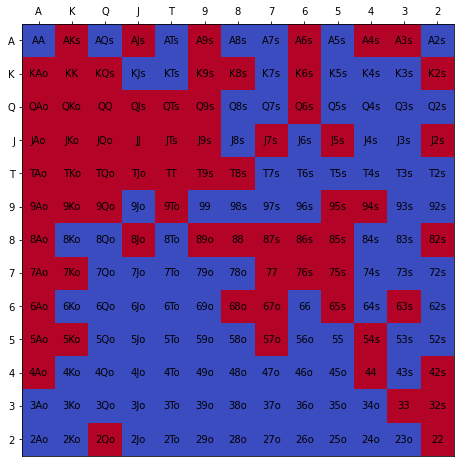

In [14]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

df_piv = createPivot(df, False)


#if left is greater than right then '--'
#else use CardValues[i] + CardValues[j] + 'o'

OffSuiteLables = np.empty((len(CardValues),len(CardValues)),dtype= 'object')


for i in range(len(CardValues)):
    for j in range(len(CardValues)):
        if j > i:
            OffSuiteLables[i][j] = '--'
        elif j==i:
            OffSuiteLables[i][j] = str(CardValues[i]) + str(CardValues[j])
        else:
            OffSuiteLables[i][j] = str(CardValues[i] + CardValues[j] +'o')


SuitedLables = np.empty((len(CardValues),len(CardValues)),dtype= 'object')


for i in range(len(CardValues)):
    for j in range(len(CardValues)):
        if j < i:
            SuitedLables[i][j] = '--'
        elif j==i:
            SuitedLables[i][j] = str(CardValues[i]) + str(CardValues[j])
        else:
            SuitedLables[i][j] = str(CardValues[i] + CardValues[j] +'s')

FullHandChartLables = np.empty((len(CardValues),len(CardValues)),dtype= 'object')
            
for i in range(len(CardValues)):
    for j in range(len(CardValues)):
        if j < i:
            FullHandChartLables[i][j] = str(CardValues[i] + CardValues[j] +'o')
        elif j==i:
            FullHandChartLables[i][j] = str(CardValues[i]) + str(CardValues[j])
        else:
            FullHandChartLables[i][j] = str(CardValues[i] + CardValues[j] +'s')


#create the suited hands and off suited, then merge into one figure
df_piv_offsuit = createPivot(df, False)
df_piv_suited = createPivot(df, True)

#replace Nan with zeros so the figures can be added
df_piv_offsuit = df_piv_offsuit.fillna(0)
df_piv_suited = df_piv_suited.fillna(0)

df_piv_combined = df_piv_suited + df_piv_offsuit

       
            
fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(CardValues)))
ax.set_yticks(np.arange(len(CardValues)))

ax.set_xticklabels(CardValues)
ax.set_yticklabels(CardValues) #set to the poker range convention

ax.xaxis.tick_top() 


df_piv_combined = df_piv_combined > 1

ax.imshow(df_piv_combined, cmap='coolwarm')

for i in range(len(CardValues)):
    for j in range(len(CardValues)):
        text = ax.text(j, i, FullHandChartLables[i, j],
                       ha="center", va="center", color="k")

set_size(6,6)
        
